# <center> Matrix factorization</center>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from math import sqrt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import scipy as sp
import scipy.sparse as scs
import matplotlib
import matplotlib.pyplot as plt
from numpy.linalg import svd
from sklearn.manifold import TSNE
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from PIL import Image
from IPython.display import display
from ipywidgets import interact, widgets

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (12, 10)
np.set_printoptions(2, suppress=True)
plt.rcParams.update({'font.size': 14})

## SVD

<img src='https://www.dataminingapps.com/wp-content/uploads/2020/02/svd2.png'>

## Matrix factorization

Попробуем применить SVD на табличных данных для задачи рекомендации. Возьмем датасет из пользователей и фильмов.

In [ ]:
ratings = pd.read_csv('../week3/data/movies_ratings.csv')
ratings

,userId,movieId,rating,timestamp,title
0,1,31,2.5,1260759144,Dangerous Minds
1,7,31,3.0,851868750,Dangerous Minds
2,31,31,4.0,1273541953,Dangerous Minds
3,32,31,4.0,834828440,Dangerous Minds
4,36,31,3.0,847057202,Dangerous Minds
...,...,...,...,...,...
99845,664,64997,2.5,1343761859,H.G. Wells' War of the Worlds
99846,664,72380,3.5,1344435977,The Box
99847,665,129,3.0,995232528,Pie in the Sky
99848,665,4736,1.0,1010197684,Summer Catch


In [ ]:
num_users, num_movies = ratings.userId.nunique(), ratings.movieId.nunique()
num_users, num_movies

(671, 9025)

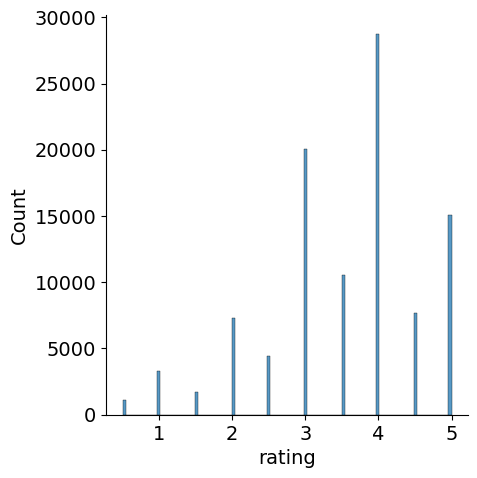

In [ ]:
sns.displot(ratings.rating);

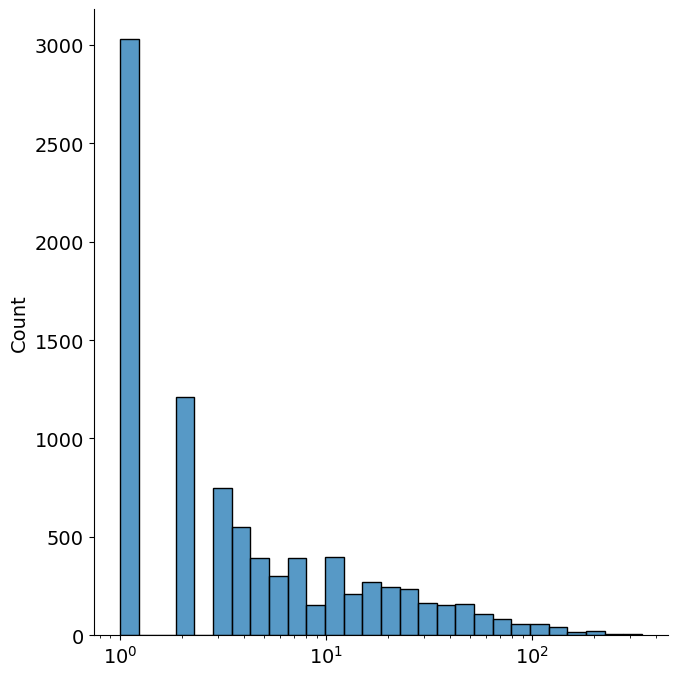

In [ ]:
sns.displot(ratings.groupby('movieId').size(), log_scale=True, height=7);

Разделим выборку на обучение и тест следующим образом: для каждого пользователя в тестовую выборку попадут 10 его последних оценок.

In [ ]:
train_ratings, test_ratings = [], []
num_test_samples = 10

for userId, user_data in ratings.groupby('userId'):
    train_ratings += [user_data[:-num_test_samples]]
    test_ratings += [user_data[-num_test_samples:]]

train_ratings = pd.concat(train_ratings)
test_ratings = pd.concat(test_ratings)
train_ratings.shape, test_ratings.shape

((93140, 5), (6710, 5))

In [ ]:
user_encoder, item_encoder = LabelEncoder(), LabelEncoder()
train_ratings['userId'] = user_encoder.fit_transform(train_ratings['userId'])
train_ratings['movieId'] = item_encoder.fit_transform(train_ratings['movieId'])


user_ids = np.array(train_ratings['userId'].tolist())
movie_ids = np.array(train_ratings['movieId'].tolist())
user_ratings = np.array(train_ratings["rating"].tolist())
print ('num of users:',train_ratings['userId'].nunique())
print ('num of movies:',train_ratings['movieId'].nunique())

num of users: 671
num of movies: 8044


In [ ]:
R = scs.coo_array((train_ratings.rating, (train_ratings.userId, train_ratings.movieId)),
                       shape=(num_users, num_movies)).tocsr()
matrix = R.toarray()

In [ ]:
U, s, V = svd(matrix)
U.shape, s.shape, V.shape

((671, 671), (671,), (9025, 9025))

In [ ]:
S = np.zeros(matrix.shape)
S[:len(s), :len(s)] = np.diag(s)
print(S.shape)
S

(671, 9025)


array([[514.18,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.  , 241.23,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  , 198.9 , ...,   0.  ,   0.  ,   0.  ],
       ...,
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]])

In [ ]:
preds_matrix = U @ S @ V

In [ ]:
preds_matrix

array([[ 0.,  0., -0., ...,  0.,  0.,  0.],
       [-0.,  0.,  0., ...,  0.,  0.,  0.],
       [-0., -0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 4.,  0., -0., ...,  0.,  0.,  0.],
       [ 5.,  0.,  0., ...,  0.,  0.,  0.]])

In [ ]:
np.allclose(matrix, preds_matrix)

True

In [ ]:
k = 20
df = pd.DataFrame(data=(zip(matrix[0, :], preds_matrix[0, :])),
                  columns=['init', 'preds']).sort_values(by='init', ascending=False)
df['preds'] = df['preds'].astype('float32')
df.sort_values(by='preds', ascending=False).head(k)

,init,preds
875,4.0,4.000000e+00
1024,3.5,3.500000e+00
781,3.0,3.000000e+00
805,3.0,3.000000e+00
30,2.5,2.500000e+00
1028,2.0,2.000000e+00
984,2.0,2.000000e+00
960,2.0,2.000000e+00
851,2.0,2.000000e+00
990,2.0,2.000000e+00


Обратите внимание, что список рекомендаций выше - смешанный, у него в топе те айтемы, которые уже были в матрице интеракций пользователя. Когда нам нужно сделать только новые рекомендации - можем профильтровать.

In [ ]:
df.sort_values(by='preds', ascending=False).head(k)[df.init == 0]

,init,preds
268,0.0,5.175027e-14
2262,0.0,4.118234e-14
500,0.0,3.387568e-14
1516,0.0,3.211320e-14
1972,0.0,3.204555e-14
31,0.0,2.997602e-14
2990,0.0,2.996214e-14
96,0.0,2.846161e-14
2169,0.0,2.828987e-14
2181,0.0,2.665923e-14


### Другие типы SVD

$$ R = U \Sigma V^T$$

- **Full SVD**
$$ UU^T = U^TU = I_M$$
$$ VV^T = V^TV = I_N,$$

где $M$ x $M$ - размер матрицы $U$, $M$ x $N$ - размер матрицы $\Sigma$, $N$ x $N$ - размер матрицы $V$.

- **Compact SVD**

Берем матрицу $\Sigma$ по размеру ранга. Compact SVD не усекает данные и предоставляет точное разложение исходной матрицы.

$$ l = rank\{R\}$$
$$ U^TU = V^TV = I_l,$$

где $M$ x $l$ - размер матрицы $U$, $l$ x $l$ - размер матрицы $\Sigma$, $l$ x $N$ - размер матрицы $V$.

- **Truncated SVD**

Берем первые k компонент диагональной матрицы $\Sigma$.

$$ k << l = rank{R}$$
$$ U^TU = V^TV = I_k,$$

где $M$ x $k$ - размер матрицы $U$,  $k$ x $k$ - размер матрицы $\Sigma$, $k$ x $N$ - размер матрицы $V$.

In [ ]:
def reshape_for_k(k: int, U, s, V):
    U_new = U[: , :k]
    S = np.zeros((U.shape[0], V.shape[1]))
    S[:len(s), :len(s)] = np.diag(s)
    S_new = S[: k, : k]
    V_new = V[: k, :]
    return U_new @ S_new @ V_new

reshape_for_k(2, U, s, V)

array([[0.02, 0.01, 0.01, ..., 0.  , 0.  , 0.  ],
       [0.54, 0.21, 0.1 , ..., 0.  , 0.  , 0.  ],
       [0.63, 0.25, 0.08, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.26, 0.1 , 0.04, ..., 0.  , 0.  , 0.  ],
       [0.46, 0.18, 0.06, ..., 0.  , 0.  , 0.  ],
       [1.8 , 0.72, 0.24, ..., 0.  , 0.  , 0.  ]])

### Обучение матриц вместо разложения

$$r_{ui} = \hat r_{ui} = p^T_{u} q_i$$

$$ \Theta = \{p_u, q_i| u \in U, i \in I\}$$

$$\sum_{(u,i) \in D}(r_{ui} - \hat r_{ui})^2 + \lambda \sum_{\theta in \Theta}) ||\theta||^2 = \sum_{(u,i) \in D}(r_{ui} - p_u^T q_i)^2 + \lambda \sum_{u \in U} ||p_u||^2 + \lambda \sum_{i \in I} ||q_i||^2 $$

In [ ]:
n_movie = train_ratings.movieId.nunique() # 8044
n_user = train_ratings.userId.nunique() # 671

embedding_size = 10
lr = 0.001
reg = 0.01

In [ ]:
n_movie, n_user

(8044, 671)

In [ ]:
user_ids = torch.LongTensor(train_ratings['userId'].values)
movie_ids = torch.LongTensor(train_ratings['movieId'].values)
user_ratings = torch.FloatTensor(train_ratings['rating'].values) # kernel

In [ ]:
class MatrixFactorization(nn.Module):

    def __init__(self, n_user, n_movie, embedding_size):
        super(MatrixFactorization, self).__init__()
        self.user_embedding = nn.Embedding(n_user, embedding_size)
        self.movie_embedding = nn.Embedding(n_movie, embedding_size)
        self.user_bias_embedding = nn.Embedding(n_user, 1)
        self.movie_bias_embedding = nn.Embedding(n_movie, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))

    def forward(self, user, movie):
        u = self.user_embedding(user)
        m = self.movie_embedding(movie)
        u_bias = self.user_bias_embedding(user).squeeze()
        m_bias = self.movie_bias_embedding(movie).squeeze()
        predicted_rating = torch.sum(u * m, dim=1) + u_bias + m_bias + self.global_bias
        return predicted_rating

In [ ]:
model = MatrixFactorization(n_user, n_movie, embedding_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

In [ ]:
batch_size = 16
n_epoch = 3

for epoch in range(n_epoch):
    for start in range(0, len(user_ratings) - batch_size, batch_size):
        end = start + batch_size
        user_batch = user_ids[start:end]
        movie_batch = movie_ids[start:end]
        rating_batch = user_ratings[start:end]

        optimizer.zero_grad()
        outputs = model(user_batch, movie_batch)
        loss = criterion(outputs, rating_batch)
        loss.backward()
        optimizer.step()

    print("RMSE", torch.sqrt(loss).item())

movie_embeddings = model.movie_embedding.weight.detach().numpy()

RMSE 0.6754335761070251
RMSE 0.6437369585037231
RMSE 0.6400254964828491
